*WORK IN PROGRESS*

Install Libraries.

In [1]:
import pandas as pd
import yfinance as yf # type: ignore
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

Load Data.

In [2]:
# tickers_ = ['SPY','NKE']
SPY_df = yf.download(tickers='SPY', auto_adjust=False)
# NKE_df = yf.download(tickers='NKE', auto_adjust=False)
INTC_df = yf.download(tickers='INTC', auto_adjust=False)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
logreturns = np.log(SPY_df['Adj Close']) - np.log(SPY_df['Adj Close'].shift(1))
SPY_df['LogReturns'] = logreturns

In [4]:
logreturns = np.log(INTC_df['Adj Close']) - np.log(INTC_df['Adj Close'].shift(1))
INTC_df['LogReturns'] = logreturns

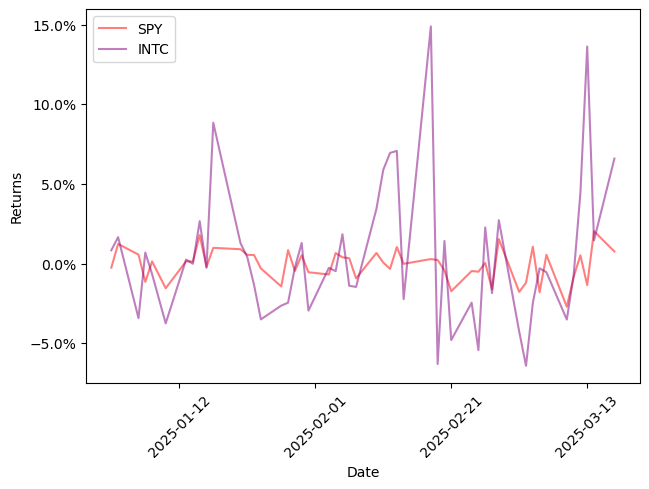

In [5]:
start_date, end_date = '2025-01-01', '2025-03-17'
plt.plot(SPY_df.loc[start_date:end_date,'LogReturns']*(100), color='red',label='SPY',alpha=0.5);
plt.plot(INTC_df.loc[start_date:end_date,'LogReturns']*(100), color='purple', label='INTC',alpha=0.5);
plt.legend();

plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(5))
plt.tight_layout()

plt.xlabel('Date');
plt.ylabel('Returns');

# Strategy 1 - Covered Calls

In [31]:
ticker = yf.Ticker('SPY')
expirations = ticker.options
option_chain = ticker.option_chain(expirations[0])
calls = option_chain.calls
calls

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,SPY250317C00400000,2025-03-17 17:56:07+00:00,400.0,167.44,166.14,167.35,7.190002,4.486741,68.0,5.0,2.800784,True,REGULAR,USD
1,SPY250317C00430000,2025-03-17 19:10:09+00:00,430.0,138.84,136.12,137.35,7.759995,5.920044,7.0,7.0,2.275395,True,REGULAR,USD
2,SPY250317C00450000,2025-03-12 18:59:38+00:00,450.0,111.44,116.14,117.35,0.000000,0.000000,NaN,NaN,1.939453,True,REGULAR,USD
3,SPY250317C00460000,2025-03-13 17:25:03+00:00,460.0,90.95,106.12,107.35,0.000000,0.000000,3.0,0.0,1.777345,True,REGULAR,USD
4,SPY250317C00470000,2025-03-14 18:24:08+00:00,470.0,90.76,96.14,97.33,0.000000,0.000000,NaN,2.0,1.591799,True,REGULAR,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,SPY250317C00660000,2025-03-14 15:32:48+00:00,660.0,0.01,0.00,0.01,0.000000,0.000000,2.0,4399.0,0.906251,False,REGULAR,USD
120,SPY250317C00665000,2025-03-06 21:02:55+00:00,665.0,0.01,0.00,0.01,0.000000,0.000000,10.0,5456.0,0.937501,False,REGULAR,USD
121,SPY250317C00670000,2025-03-05 17:42:20+00:00,670.0,0.01,0.00,0.01,0.000000,0.000000,NaN,1.0,0.968750,False,REGULAR,USD
122,SPY250317C00675000,2025-03-05 17:12:22+00:00,675.0,0.01,0.00,0.01,0.000000,0.000000,NaN,63.0,1.031255,False,REGULAR,USD
